In [1]:
import lettuce as lt
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np
from lettuce.boundary import EquilibriumBoundaryPU, EquilibriumOutletP, AntiBounceBackOutlet
from lettuce.observables import Observable
from lettuce.unit import UnitConversion
from lettuce.util import append_axes
from lettuce import ObstacleMax3D
from lettuce.flows.obstacleCylinder import ObstacleCylinder
import torch
import time
import datetime
import os
import psutil
import shutil
from pyevtk.hl import imageToVTK

In [2]:
### OUTPUT SETTINGS
output_data = True
output_vtk = False # is overwritten with False if output_data=False (see below)
vtk_fps = 10
calculate_velocity_profile = False  # outputs plots and time-averaged data for plots
output_velocity_profile = False  # outputs the full time series (!)

# IMPORTANT: set correct output_path, for example "/home/YourUserName/simulation_output"
output_path = "/mnt/ScratchHDD1/Max_Scratch/lbm_simulations"  # lokal HBRS
#output_path = "/home/max/Documents/lbm_simulations"  # lokal Bonn
#output_path = "/home/mbille3s/02_lbm_simulations"  # cluster HBRS

# IMPORTANT: set correct input_path for reference data:
diIlio_path = '/home/mbille/lettuce/myTest/DiIlio_data/'  # likal HBRS
# diIlio_path = '/scratch/mbille3s/21_LBM/03_reference_data/DiIlio_2018/'  # cluster HBRS

# name: if you want something specific in the dir-name
name = "cyl3D_test_hwbbc_hwbbc3"

# choose stencil: "D3Q9" dor 2D, "D3Q15", "D3Q19", "D3Q27" for 3D
stencil_choice = "D3Q27"
# choose collision operator: "bgk, "kbc", "reg"
collision_choice = "bgk"

In [3]:
### SIMULATION PARAMETERS (and estimation of timesteps needed to reach T_target)
re = 200   # Reynoldsnumber
Ma = 0.05     # Machnumber
n_steps = 100 #145492 # number of steps
setup_diameter = 1  # D_PU = char_length_pu -> this defines the PU-Reference
flow_velocity = 1  # U_PU = char_velocity_pu -> this defines the PU-Reference velocity (u_max of inflow)

# relative starting point for drag-measurement (make sure periodic state is reached)
periodic_start = 0.9  # relative start of peak_finding for Cd_mean Measurement to cut of any transients

# GEOMETRY
gridpoints_per_diameter = 16  # gp_per_D = GPD -> this defines the resolution ( D_LU = GPD)
domain_height_in_D = 10  # D/Y = DpY = diameters per domain width in Y-direction -> this defines the domain-size and total number of Lattice-Nodes
domain_length_in_D = 2 * domain_height_in_D  # D/X = domain length in X- / flow-direction
domain_width_in_D = 3 #domain_height_in_D #1/gridpoints_per_diameter  # D/Z = DpZ = diameters per domain width in Z-direction -> domain size in periodic 3rd dimension

# RELATION [GPD to DpY] check
# if DpY is even, resulting GPD can't be odd for symmetrical cylinder and channel
# ...if DpY is even, GPD will be corrected to even GPD for symmetrical cylinder
# ...use odd DpY to use odd GPD
gpd_correction=False
if domain_height_in_D % 2 == 0 and gridpoints_per_diameter % 2 != 0:
    gpd_correction = True   # gpd_was_corrected-flag
    gpd_setup = gridpoints_per_diameter   # store old gpd for output
    gridpoints_per_diameter = int(gridpoints_per_diameter/2)*2   # make gpd even
    print("(!) domain_height_in_D is even, gridpoints_per_diameter will be "+str(gridpoints_per_diameter)+". Use odd domain_height_in_D to enable use of odd GPD!")

# SIMULATOR settings
u_init = 0    # initial velocity field: # 0: uniform u=0, # 1: uniform u=1, # 2: parabolic, amplitude u_char_lu (similar to poiseuille-flow)
perturb_init = True   # perturb initial symmetry by small sine-wave in initial velocity field -> triggers Karman-vortex street for Re > 46
lateral_walls='periodic'  # type of top/bottom boundary: 'bounceback' = frictious wall, 'periodic' = periodic boundary, 'slip' = non-frictious wall
bc_type='hwbbc3'  # choose algorithm for bounceback-boundaries: fullway 'fwbb', halfway 'hwbb', linear interpolated 'ibb1'

# T_PU to n_steps estimation: (for example for Re=200 the periodic state is reached for T_PU > 140)
T_target=200
print("shape_LU:", gridpoints_per_diameter*domain_length_in_D, "x", gridpoints_per_diameter*domain_height_in_D, "x", gridpoints_per_diameter*domain_width_in_D)
print("T with", n_steps, "steps:", round(n_steps * (setup_diameter/(gridpoints_per_diameter))*(Ma*1/np.sqrt(3)/flow_velocity),2), "seconds")
print("n_steps to simulate 1 second:", round(((gridpoints_per_diameter)/setup_diameter)*(flow_velocity/(Ma*1/np.sqrt(3))),2), "steps")
print("n_steps to simulate",T_target,"seconds:",T_target*round(((gridpoints_per_diameter)/setup_diameter)*(flow_velocity/(Ma*1/np.sqrt(3))),2), "steps")


mlups_2060super = 20
mlups_2080ti = 30   # 40 for GPD30,DpY19,nsteps=150000 (steigend mit der Auflösung)

if output_vtk:
    print("generates approx.", int(vtk_fps*(n_steps * (setup_diameter/(gridpoints_per_diameter))*(Ma*1/np.sqrt(3)/flow_velocity)))+1, ".vti/.vtk-frames")

gridpoints = gridpoints_per_diameter**3*domain_length_in_D*domain_height_in_D*domain_width_in_D
print("No. of gridpoints:", gridpoints)

shape_LU: 320 x 160 x 48
T with 100 steps: 0.18 seconds
n_steps to simulate 1 second: 554.26 steps
n_steps to simulate 200 seconds: 110852.0 steps
No. of gridpoints: 2457600


In [4]:
### (no user input) CREATE OUTPUT DIRECTORIES
if output_data:  # toggle output
    timestamp = datetime.datetime.now()
    timestamp = timestamp.strftime("%y%m%d")+"_"+timestamp.strftime("%H%M%S")

    dir_name = "/data_" + str(timestamp) + "_" + name + "_GPD" + str(gridpoints_per_diameter) + "_" + str(domain_length_in_D) + "x" + str(domain_height_in_D) + "x" + str(domain_width_in_D) + "_" + str(stencil_choice)
    os.makedirs(output_path+dir_name)

    if output_vtk:
        vtk_path = output_path+dir_name+"/vtk/out"
        print("vtk_path: " + vtk_path)
    print("dir_name: "+dir_name)

    if calculate_velocity_profile:
        os.makedirs(output_path+dir_name+"/AvgVelocity_Data")
else:
    output_vtk = False

dir_name: /data_231006_131730_cyl3D_test_hwbbc_hwbbc3_GPD16_20x10x3_D3Q27


In [5]:
### SIMULATOR SETUP

# stencil
if stencil_choice == "D3Q15":
    stencil=lt.D3Q15
elif stencil_choice == "D3Q19":
    stencil=lt.D3Q19
else: # stencil_choice=="D3Q27"
    stencil=lt.D3Q27

# lattice
# lattice = lt.Lattice(lt.D2Q9, "cuda:0", dtype=torch.float64, native=False)  # for "new lettuce"
lattice = lt.Lattice(stencil, "cuda:0", dtype=torch.float64)  #for "old lettuce"
    # stencil, device, dtype

# flow = ObstacleMax3D(reynolds_number=re, mach_number=Ma,
#                    lattice=lattice,
#                    char_length_pu=setup_diameter,
#                    char_length_lu=gridpoints_per_diameter,
#                    char_velocity_pu=flow_velocity,
#                    x_lu=domain_length_in_D*gridpoints_per_diameter,
#                    y_lu=domain_height_in_D*gridpoints_per_diameter,
#                    z_lu=domain_width_in_D*gridpoints_per_diameter,
#                    lateral_walls=lateral_walls,
#                    bb_type=bb_type,
#                    perturb_init=perturb_init,
#                    u_init=u_init
#                   )
flow = ObstacleCylinder(shape=(domain_length_in_D*gridpoints_per_diameter,
                               domain_height_in_D*gridpoints_per_diameter,
                               domain_width_in_D*gridpoints_per_diameter),
                        reynolds_number=re, mach_number=Ma,
                        lattice=lattice,
                        char_length_pu=setup_diameter,
                        char_length_lu=gridpoints_per_diameter,
                        char_velocity_pu=flow_velocity,
                        lateral_walls=lateral_walls,
                        bc_type=bc_type,
                        perturb_init=perturb_init,
                        u_init=u_init
                        )

# # define a Cylinder-Obstacle
# radius_LU = 0.5 * gridpoints_per_diameter
# y_pos_LU = 0.5 * gridpoints_per_diameter * domain_height_in_D + 0.5
# x_pos_LU = y_pos_LU
#
# index_list = tuple(np.linspace(1,n,n) for n in flow.shape)  # Tupel index lists (1-n (non zero-based!))
# xLU, yLU, zLU = np.meshgrid(*index_list, indexing='ij')  # meshgrid of x-, y- (and z-)indizes/indexs?/indexes?! - this is simulation, not grammar...
#
# condition = np.sqrt((xLU - x_pos_LU) ** 2 + (yLU - y_pos_LU) ** 2) < radius_LU
# flow.obstacle_mask[np.where(condition)] = 1

### simulation object (simulator)
tau = flow.units.relaxation_parameter_lu  # relaxation parameter
re_g = flow.units.characteristic_velocity_lu/(lattice.stencil.cs**2 * (tau-0.5))  # grid reynolds number (should be O(10))

# collision
if collision_choice == "reg":
    collision=lt.RegularizedCollision(lattice, tau)
elif collision_choice == "kbc":
    collision=lt.KBCCollision3D(lattice,tau)
else: # collision_choice = "bgk":
    collision=lt.BGKCollision(lattice, tau)

# simulation
sim = lt.Simulation(flow, lattice,
                    collision,
                    # lt.BGKCollision(lattice, tau),
                    # lt.RegularizedCollision(lattice, tau),
                    # lt.KBCCollision2D(lattice,tau),
                    lt.StandardStreaming(lattice)
                   )
    # Flow, Lattice-Parameter, CollisionOperator-Object(Parameter), Streaming-Object

### Reporter

# VTK Reporter -> Visualization
if output_vtk:
    VTKreport = lt.VTKReporter(lattice, flow, interval=int(flow.units.convert_time_to_lu(1/vtk_fps)), filename_base=vtk_path)
    sim.reporters.append(VTKreport)
    # export obstacle
    mask_dict = dict()
    mask_dict["mask"] = flow.obstacle_mask.astype(int)
    imageToVTK(
        path=output_path+dir_name+"/vtk/obstacle_point",
        pointData=mask_dict
    )
    imageToVTK(
        path=output_path+dir_name+"/vtk/obstacle_cell",
        cellData=mask_dict
    )

# Observable reporter: drag coefficient
DragObservable = lt.DragCoefficient(lattice,flow,sim._boundaries[-1],area=setup_diameter*flow.units.convert_length_to_pu(gridpoints_per_diameter*domain_width_in_D))  # ! area A=2*r is in PU and 1-dimensional in 2D
Dragreport = lt.ObservableReporter(DragObservable, out=None)
sim.reporters.append(Dragreport)

# Observable reporter: lift coefficient
LiftObservable = lt.LiftCoefficient(lattice,flow,sim._boundaries[-1],area=setup_diameter*flow.units.convert_length_to_pu(gridpoints_per_diameter*domain_width_in_D))
Liftreport = lt.ObservableReporter(LiftObservable, out=None)
sim.reporters.append(Liftreport)

/home/mbille/lettuce/lettuce/boundary.py:1576: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.stencil_e_tensor_index = torch.tensor(self.lattice.e, device=self.lattice.device, dtype=torch.int64)


In [6]:
# AverageVelocity Reporter:
if calculate_velocity_profile:
    # define positions
    position_1 = flow.x_pos-0.5 + 1.06 * flow.radius * 2  #int(round(flow.x_pos + 1.06 * flow.radius * 2 , 0))
    position_2 = flow.x_pos-0.5 + 1.54 * flow.radius * 2  #int(round(flow.x_pos + 1.54 * flow.radius * 2 , 0))
    position_3 = flow.x_pos-0.5 + 2.02 * flow.radius * 2  #int(round(flow.x_pos + 2.02 * flow.radius * 2 , 0))
    print("V_avg positions:" + " p1: " + str(position_1) + " p2:  " + str(position_2) + " p3:  " + str(position_3))

    # create and append AvgVelocity-reporter
    AvgVelocity1 = lt.AverageVelocityReporter(lattice,flow, position_1)
    sim.reporters.append(AvgVelocity1)
    AvgVelocity2 = lt.AverageVelocityReporter(lattice,flow, position_2)
    sim.reporters.append(AvgVelocity2)
    AvgVelocity3 = lt.AverageVelocityReporter(lattice,flow, position_3)
    sim.reporters.append(AvgVelocity3)

In [7]:
# NaNReporter: stop if NaN is detected (default interval is 100 steps)
NaNReporter = lt.NaNReporter(flow, lattice, n_steps, T_target)  # default interval of 100
sim.reporters.append(NaNReporter)

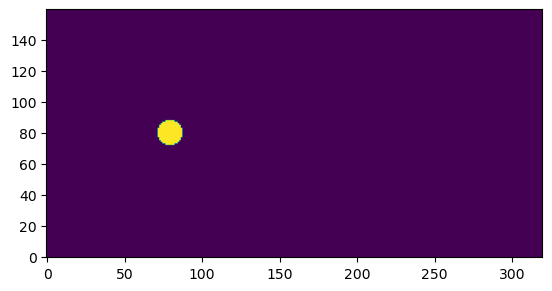

In [8]:
# show domain slice
try:
    plt.imshow(sim._boundaries[-1].mask[:,:,0].T, origin="lower")
except:
    try:
        plt.imshow(lattice.convert_to_numpy(sim._boundaries[-1].mask[:,:,0].T), origin="lower")
    except:
        print("did not work...")

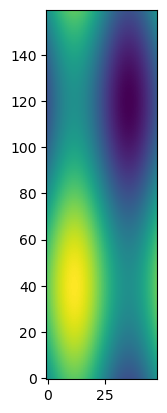

In [9]:
# show pertubation in x=1 slice
plt.imshow(lattice.convert_to_numpy(lattice.u(sim.f))[0,1,:,:], origin="lower")

In [10]:
### grid reynolds number
print(re_g)

12.499999999999938


In [11]:
### export parameters

if output_data:
    output_file = open(output_path+dir_name+"/"+timestamp + "_parameters.txt", "a")
    output_file.write("DATA for "+timestamp)
    output_file.write("\n\n###   SIM-Parameters   ###")
    output_file.write("\nRe = "+str(re))
    output_file.write("\nn_steps = "+str(n_steps))
    output_file.write("\nT_target = "+str(flow.units.convert_time_to_pu(n_steps))+" seconds")
    output_file.write("\ngridpoints_per_diameter (gpd) = "+str(gridpoints_per_diameter))
    if gpd_correction:
        output_file.write("\ngpd was corrected from: "+str(gpd_setup)+" to "+str(gridpoints_per_diameter)+" because D/Y is even")
    output_file.write("\nDpX (D/X) = " + str(domain_length_in_D))
    output_file.write("\nDpY (D/Y) = "+str(domain_height_in_D))
    if lattice.D == 3:
        output_file.write("\nDpZ (D/Z) = "+str(domain_width_in_D))
    output_file.write("\nshape_LU: "+ str(flow.shape))
    output_file.write(("\ntotal_number_of_gridpoints: "+str(lattice.rho(sim.f).numel())))
    output_file.write("\nbc_type = "+str(bc_type))
    output_file.write("\nlateral_walls = "+str(lateral_walls))
    output_file.write("\nstencil = "+str(stencil_choice))
    output_file.write("\ncollision = " + str(collision_choice))
    output_file.write("\n")
    output_file.write("\nMa = " + str(Ma))
    output_file.write("\ntau = " + str(tau))
    output_file.write("\ngrid_reynolds_number (Re_g) = " + str(re_g))
    output_file.write("\n")
    output_file.write("\nsetup_diameter_PU = " + str(setup_diameter))
    output_file.write("\nflow_velocity_PU = " + str(flow_velocity))
    output_file.write("\nu_init = " + str(u_init))
    output_file.write("\nperturb_init = " + str(perturb_init))
    output_file.write("\n")
    output_file.write("\noutput_vtk = " + str(output_vtk))
    output_file.write("\nvtk_fps = " + str(vtk_fps))
    output_file.close()

GPD = 16
area_rel: 1.0345071300973196


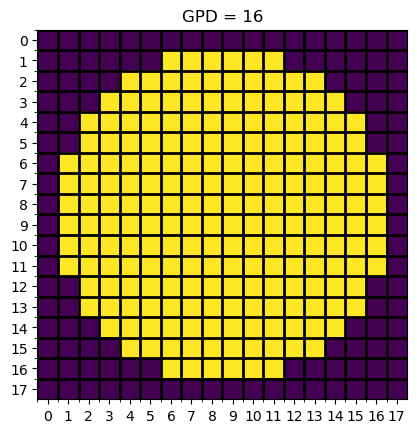

In [12]:
### calculate and export 2D obstacle_mask as .png

grid_x = gridpoints_per_diameter+2
if output_data:
    output_file = open(output_path+dir_name +"/"+timestamp + "_obstacle_mask_info.txt", "a")
    output_file.write("GPD = " + str(gridpoints_per_diameter)+"\n")
    print("GPD = " + str(gridpoints_per_diameter))
    # define radius and position for a symetrical circular Cylinder-Obstacle
    radius_LU = 0.5 * gridpoints_per_diameter
    y_pos_LU = 0.5 * grid_x + 0.5
    x_pos_LU = y_pos_LU

    # get x,y,z meshgrid of the domain (LU)
    xyz = tuple(np.linspace(1, n, n) for n in (grid_x,grid_x))  # Tupel aus Listen indizes (1-n (nicht 0-based!))
    xLU, yLU = np.meshgrid(*xyz, indexing='ij')  # meshgrid aus den x-, y- (und z-)Indizes -> * damit man die einzelnen Einträge des Tupels übergibt, und nicht das eine Tupel

    # define cylinder (LU)
    obstacle_mast_for_visualization = np.sqrt((xLU - x_pos_LU) ** 2 + (yLU - y_pos_LU) ** 2) < radius_LU

    nx, ny = obstacle_mast_for_visualization.shape  # Anzahl x-Punkte, Anzahl y-Punkte (Skalar), (der gesamten Domain)

    rand_mask = np.zeros((nx, ny), dtype=bool)  # für Randpunkte, die es gibt
    rand_mask_f = np.zeros((lattice.Q, nx, ny), dtype=bool)  # für Randpunkte (inkl. Q-Dimension)
    rand_xq = []  # Liste aller x Werte (inkl. q-multiplizität)
    rand_yq = []  # Liste aller y Werte (inkl. q-multiplizität)

    a, b = np.where(obstacle_mast_for_visualization)  # np.array: Liste der (a) x-Koordinaten  und (b) y-Koordinaten der obstacle_mast_for_visualization
    # ...um über alle Boundary/Objekt/Wand-Knoten iterieren zu können
    for p in range(0, len(a)):  # für alle TRUE-Punkte der obstacle_mast_for_visualization
        for i in range(0, lattice.Q):  # für alle stencil-Richtungen c_i (hier lattice.stencil.e)
            try:  # try in case the neighboring cell does not exist (an f pointing out of the simulation domain)
                if not obstacle_mast_for_visualization[a[p] + lattice.stencil.e[i, 0], b[p] + lattice.stencil.e[i, 1]]:
                    # falls in einer Richtung Punkt+(e_x, e_y; e ist c_i) False ist, ist das also ein Oberflächenpunkt des Objekts (selbst True mit Nachbar False)
                    rand_mask[a[p], b[p]] = 1
                    rand_mask_f[lattice.stencil.opposite[i], a[p], b[p]] = 1
                    rand_xq.append(a[p])
                    rand_yq.append(b[p])
            except IndexError:
                pass  # just ignore this iteration since there is no neighbor there
    rand_x, rand_y = np.where(rand_mask)  # Liste aller Rand-x- und y-Koordinaten
    x_pos = sum(rand_x)/len(rand_x)  # x_Koordinate des Kreis-Zentrums
    y_pos = sum(rand_y)/len(rand_y)  # y-Koordinate des Kreis-Zentrums

    # calculate all radii and r_max and r_min
    r_max = 0
    r_min = gridpoints_per_diameter
    radii = np.zeros_like(rand_x, dtype=float)  # Liste aller Radien (ohne q) in LU
    for p in range(0, len(rand_x)):  # für alle Punkte
        radii[p] = np.sqrt((rand_x[p]-x_pos)**2 + (rand_y[p]-y_pos)**2)  # berechne Abstand des Punktes zum Zentrum
        if radii[p] > r_max:
            r_max = radii[p]
        if radii[p] < r_min:
            r_min = radii[p]

    # calculate all radii (with q-multiplicity)
    radii_q = np.zeros_like(rand_xq, dtype=float)
    for p in range(0, len(rand_xq)):
        radii_q[p] = np.sqrt((rand_xq[p]-x_pos)**2 + (rand_yq[p]-y_pos)**2)

    ### all relative radii in relation to gpd/2
    radii_relative = radii / (radius_LU-0.5)  # (substract 0.5 because "true" boundary location is 0.5LU further out than node-coordinates)
    radii_q_relative = radii_q / (radius_LU-0.5)

    # calc. mean rel_radius
    r_rel_mean = sum(radii_relative)/len(radii_relative)
    rq_rel_mean = sum(radii_q_relative)/len(radii_q_relative)

    ## AREA calculation
    area_theory = np.pi*(gridpoints_per_diameter/2)**2  # area = pi*r² in LU²
    area = len(a)  # area in LU = number of nodes, because every node has a cell of 1LU x 1LU around it

    output_file.write("\nr_rel_mean: " + str(sum(radii_relative)/len(radii_relative)))
    output_file.write("\nrq_rel_mean: " + str(sum(radii_q_relative)/len(radii_q_relative)))
    output_file.write("\nr_rel_min: " + str(r_max/(radius_LU-0.5)))
    output_file.write("\nr_rel_max: " + str(r_min/(radius_LU-0.5)))
    output_file.write("\n\narea_rel: " + str(area/area_theory))
    print("area_rel: " + str(area/area_theory))

    from collections import Counter
    output_file.write("\n\nradii: " + str(Counter(radii)))
    output_file.write("\nradii_q: " + str(Counter(radii_q))+"\n\n")
    output_file.close()

    ### PLOT Mask
    plt.figure()
    plt.imshow(obstacle_mast_for_visualization)
    #plt.xticks(np.arange(gridpoints_per_diameter + 2), minor=True)
    #plt.yticks(np.arange(gridpoints_per_diameter + 2), minor=True)
    ax = plt.gca()
    xmin, xmax = ax.get_xlim()
    ymax, ymin = ax.get_ylim()
    if gridpoints_per_diameter >= 10:
        plt.xticks(np.arange(0, xmax, int(xmax/10)))
        plt.yticks(np.arange(0, ymax, int(ymax/10)))
    else:
        plt.xticks(np.arange(0, xmax, 1))
        plt.yticks(np.arange(0, ymax, 1))
    plt.title("GPD = "+str(gridpoints_per_diameter))
    ax.set_xticks(np.arange(-.5, xmax, 1), minor=True)
    ax.set_yticks(np.arange(-.5, ymax, 1), minor=True)
    if gridpoints_per_diameter < 30:
        ax.grid(which="minor", color="k", axis='both', linestyle='-', linewidth=2)
    elif gridpoints_per_diameter < 70:
        ax.grid(which="minor", color="k", axis='both', linestyle='-', linewidth=1)
    elif gridpoints_per_diameter < 100:
        ax.grid(which="minor", color="k", axis='both', linestyle='-', linewidth=0.5)
    elif gridpoints_per_diameter < 150:
        ax.grid(which="minor", color="k", axis='both', linestyle='-', linewidth=0.25)
    plt.savefig(output_path+dir_name +"/"+timestamp + "obtacle_mask_GPD" + str(gridpoints_per_diameter) + ".png")
    #plt.close()

GPD = 16
area_rel: 1.0345071300973196


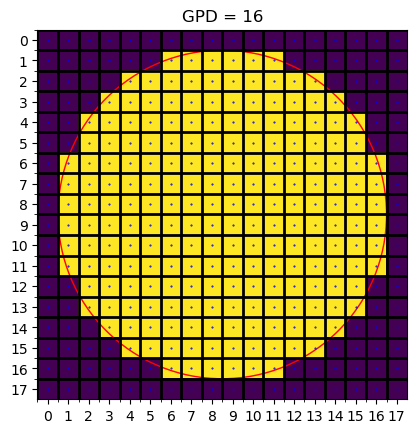

In [13]:
from lettuce.max import draw_circular_mask
draw_circular_mask(lattice, gridpoints_per_diameter, output_data=True, filebase=output_path+dir_name, print_data=True)

# SIMULATION

In [14]:
### simple simulation

t_start=time.time()

mlups = sim.step(n_steps) #simulation

t_end=time.time()
runtime=t_end-t_start
print("MLUPS:", mlups)
print("PU-Time: ",flow.units.convert_time_to_pu(n_steps)," seconds")
print("number of steps:",n_steps)
print("runtime: ",runtime, "seconds (", round(runtime/60,2),"minutes )")

c_time = sim.time_avg["time_collision"]
s_time = sim.time_avg["time_streaming"]
b_time = sim.time_avg["time_boundary"]
r_time = sim.time_avg["time_reporter"]
sum_time = sim.time_avg["time_collision"] + sim.time_avg["time_streaming"] + sim.time_avg["time_boundary"] + sim.time_avg["time_reporter"]

print("collision avg. time:", sim.time_avg["time_collision"], "seconds (" + str(round(100 * c_time/sum_time, 2)) + " %)")
print("streaming avg. time:", sim.time_avg["time_streaming"], "seconds (" + str(round(100 * s_time/sum_time, 2)) + " %)")
print("boundary avg. time:", sim.time_avg["time_boundary"], "seconds (" + str(round(100 * b_time/sum_time, 2)) + " %)")
print("reporter avg. time:", sim.time_avg["time_reporter"], "seconds (" + str(round(100 * r_time/sum_time, 2)) + " %)")

print("current GPU VRAM (MB): ", torch.cuda.memory_allocated(device="cuda:0")/1024/1024)
print("max. GPU VRAM (MB): ", torch.cuda.max_memory_allocated(device="cuda:0")/1024/1024)

[cpuLoad1,cpuLoad5,cpuLoad15] = [x / psutil.cpu_count() * 100 for x in psutil.getloadavg()]
print("CPU % avg. over last 1 min, 5 min, 15 min; ", round(cpuLoad1,2), round(cpuLoad5,2), round(cpuLoad15,2))

ram = psutil.virtual_memory()
print("current total RAM usage [MB]: " + str(round(ram.used/(1024*1024),2)) + " of " + str(round(ram.total/(1024*1024),2)) + " MB")

MLUPS: 11.235591024333853
PU-Time:  0.18042195912175807  seconds
number of steps: 100
runtime:  21.87346076965332 seconds ( 0.36 minutes )
collision avg. time: 0.00042452949997823453 seconds (0.19 %)
streaming avg. time: 0.0008831356100199628 seconds (0.4 %)
boundary avg. time: 0.0030235854199963798 seconds (1.38 %)
reporter avg. time: 0.21433701288999146 seconds (98.02 %)
current GPU VRAM (MB):  580.28564453125
max. GPU VRAM (MB):  2699.03564453125
CPU % avg. over last 1 min, 5 min, 15 min;  1.97 1.89 1.29
current total RAM usage [MB]: 7229.71 of 64220.01 MB


In [15]:
### export stats
if output_data:
    output_file = open(output_path+dir_name+"/"+timestamp + "_stats.txt", "a")
    output_file.write("DATA for "+timestamp)
    output_file.write("\n\n###   SIM-STATS  ###")
    output_file.write("\nruntime = "+str(runtime)+ " seconds (="+str(runtime/60)+" minutes)")
    output_file.write("\nMLUPS = "+str(mlups))
    output_file.write("\n")
    output_file.write("\navg. Collision-Time [s] = " + str(c_time) + " (" + str(round(100 * c_time/sum_time, 2)) + " %)")
    output_file.write("\navg. Streaming-Time [s] = " + str(s_time) + " (" + str(round(100 * s_time/sum_time, 2)) + " %)")
    output_file.write("\navg. Boundary-Time  [s] = " + str(b_time) + " (" + str(round(100 * b_time/sum_time, 2)) + " %)")
    output_file.write("\navg. Reporter-Time  [s] = " + str(r_time) + " (" + str(round(100 * r_time/sum_time, 2)) + " %)")
    output_file.write("\n")
    output_file.write("\nVRAM_current [MB] = " + str(torch.cuda.memory_allocated(lattice.device)/1024/1024))
    output_file.write("\nVRAM_peak [MB] = " + str(torch.cuda.max_memory_allocated(lattice.device)/1024/1024))
    output_file.write("\n")
    output_file.write("\nCPU load % avg. over last 1, 5, 15 min: " + str(round(cpuLoad1, 2)) + " %, " + str(round(cpuLoad5, 2)) + " %, " + str(round(cpuLoad15, 2)) + " %")
    output_file.write("\ntotal current RAM usage [MB]: " + str(round(ram.used/(1024*1024),2)) + " of " + str(round(ram.total/(1024*1024),2)) + " MB")
    output_file.close()

In [16]:
# # Output Clock
#
# print("Clock:")
# print(np.array(Clock.out))

In [17]:
# p1_LS1993 = np.genfromtxt('/home/mbille/lettuce/myTest/DiIlio_Fig09_data/Fig09_ux_profile_pos1_LS1993.csv', delimiter=';')
# plt.plot(p1_LS1993[:,0], p1_LS1993[:,1])

# Avg Velocity

In [18]:
# plot AvgVelocity (ist per Reporter schon in PU, normalisierung mit u_char nicht nötig, da u_char = 1 in PU)

if calculate_velocity_profile:
    avg_u_start = 0.5

    # import reference data: (data is: first collumn Y/D, second column u_d/u_char)
    # ux
    p1_LS1993_ux = np.genfromtxt(diIlio_path + 'Fig09_ux_profile_pos1_LS1993.csv', delimiter=';')
    p2_LS1993_ux = np.genfromtxt(diIlio_path + 'Fig09_ux_profile_pos2_LS1993.csv', delimiter=';')
    p3_LS1993_ux = np.genfromtxt(diIlio_path + 'Fig09_ux_profile_pos3_LS1993.csv', delimiter=';')

    p1_KM2000_ux = np.genfromtxt(diIlio_path + 'Fig09_ux_profile_pos1_KM2000.csv', delimiter=';')
    p2_KM2000_ux = np.genfromtxt(diIlio_path + 'Fig09_ux_profile_pos2_KM2000.csv', delimiter=';')
    p3_KM2000_ux = np.genfromtxt(diIlio_path + 'Fig09_ux_profile_pos3_KM2000.csv', delimiter=';')

    p1_WR2008_ux = np.genfromtxt(diIlio_path + 'Fig09_ux_profile_pos1_WR2008.csv', delimiter=';')
    p2_WR2008_ux = np.genfromtxt(diIlio_path + 'Fig09_ux_profile_pos2_WR2008.csv', delimiter=';')
    p3_WR2008_ux = np.genfromtxt(diIlio_path + 'Fig09_ux_profile_pos3_WR2008.csv', delimiter=';')

    p1_DI2018_ux = np.genfromtxt(diIlio_path + 'Fig09_ux_profile_pos1_DI2018.csv', delimiter=';')
    p2_DI2018_ux = np.genfromtxt(diIlio_path + 'Fig09_ux_profile_pos2_DI2018.csv', delimiter=';')
    p3_DI2018_ux = np.genfromtxt(diIlio_path + 'Fig09_ux_profile_pos3_DI2018.csv', delimiter=';')

    # uy
    p1_LS1993_uy = np.genfromtxt(diIlio_path + 'Fig10_uy_profile_pos1_LS1993.csv', delimiter=';')
    p2_LS1993_uy = np.genfromtxt(diIlio_path + 'Fig10_uy_profile_pos2_LS1993.csv', delimiter=';')
    p3_LS1993_uy = np.genfromtxt(diIlio_path + 'Fig10_uy_profile_pos3_LS1993.csv', delimiter=';')

    p1_KM2000_uy = np.genfromtxt(diIlio_path + 'Fig10_uy_profile_pos1_KM2000.csv', delimiter=';')
    p2_KM2000_uy = np.genfromtxt(diIlio_path + 'Fig10_uy_profile_pos2_KM2000.csv', delimiter=';')
    p3_KM2000_uy = np.genfromtxt(diIlio_path + 'Fig10_uy_profile_pos3_KM2000.csv', delimiter=';')

    p1_WR2008_uy = np.genfromtxt(diIlio_path + 'Fig10_uy_profile_pos1_WR2008.csv', delimiter=';')
    p2_WR2008_uy = np.genfromtxt(diIlio_path + 'Fig10_uy_profile_pos2_WR2008.csv', delimiter=';')
    p3_WR2008_uy = np.genfromtxt(diIlio_path + 'Fig10_uy_profile_pos3_WR2008.csv', delimiter=';')

    p1_DI2018_uy = np.genfromtxt(diIlio_path + 'Fig10_uy_profile_pos1_DI2018.csv', delimiter=';')
    p2_DI2018_uy = np.genfromtxt(diIlio_path + 'Fig10_uy_profile_pos2_DI2018.csv', delimiter=';')
    p3_DI2018_uy = np.genfromtxt(diIlio_path + 'Fig10_uy_profile_pos3_DI2018.csv', delimiter=';')

    # uxux
    p1_DI2018_uxux = np.genfromtxt(diIlio_path + 'Fig11_uxux_profile_pos1_DI2018.csv', delimiter=';')
    p1_KM2000_uxux = np.genfromtxt(diIlio_path + 'Fig11_uxux_profile_pos1_KM2000.csv', delimiter=';')
    p1_R2016_uxux  = np.genfromtxt(diIlio_path + 'Fig11_uxux_profile_pos1_R2016.csv', delimiter=';')
    p2_BM1994_uxux = np.genfromtxt(diIlio_path + 'Fig11_uxux_profile_pos2_BM1994.csv', delimiter=';')
    p2_DI2018_uxux = np.genfromtxt(diIlio_path + 'Fig11_uxux_profile_pos2_DI2018.csv', delimiter=';')
    p2_KM2000_uxux = np.genfromtxt(diIlio_path + 'Fig11_uxux_profile_pos2_KM2000.csv', delimiter=';')
    p2_LS1993_uxux = np.genfromtxt(diIlio_path + 'Fig11_uxux_profile_pos2_LS1993.csv', delimiter=';')
    p2_R2016_uxux  = np.genfromtxt(diIlio_path + 'Fig11_uxux_profile_pos2_R2016.csv', delimiter=';')
    p3_DI2018_uxux = np.genfromtxt(diIlio_path + 'Fig11_uxux_profile_pos3_DI2018.csv', delimiter=';')
    p3_KM2000_uxux = np.genfromtxt(diIlio_path + 'Fig11_uxux_profile_pos3_KM2000.csv', delimiter=';')
    p3_R2016_uxux  = np.genfromtxt(diIlio_path + 'Fig11_uxux_profile_pos3_R2016.csv', delimiter=';')

    # uyuy
    p1_DI2018_uyuy = np.genfromtxt(diIlio_path + 'Fig12_uyuy_profile_pos1_DI2018.csv', delimiter=';')
    p1_R2016_uyuy = np.genfromtxt(diIlio_path + 'Fig12_uyuy_profile_pos1_R2016.csv', delimiter=';')
    p2_BM1994_uyuy = np.genfromtxt(diIlio_path + 'Fig12_uyuy_profile_pos2_BM1994.csv', delimiter=';')
    p2_DI2018_uyuy = np.genfromtxt(diIlio_path + 'Fig12_uyuy_profile_pos2_DI2018.csv', delimiter=';')
    p2_LS1993_uyuy = np.genfromtxt(diIlio_path + 'Fig12_uyuy_profile_pos2_LS1993.csv', delimiter=';')
    p2_R2016_uyuy = np.genfromtxt(diIlio_path + 'Fig12_uyuy_profile_pos2_R2016.csv', delimiter=';')
    p3_DI2018_uyuy = np.genfromtxt(diIlio_path + 'Fig12_uyuy_profile_pos3_DI2018.csv', delimiter=';')
    p3_R2016_uyuy = np.genfromtxt(diIlio_path + 'Fig12_uyuy_profile_pos3_R2016.csv', delimiter=';')

    # uxuy
    p1_BM1994_uxuy = np.genfromtxt(diIlio_path + 'Fig13_uxuy_profile_pos1_BM1994.csv', delimiter=';')
    p1_DI2018_uxuy = np.genfromtxt(diIlio_path + 'Fig13_uxuy_profile_pos1_DI2018.csv', delimiter=';')
    p1_R2016_uxuy = np.genfromtxt(diIlio_path + 'Fig13_uxuy_profile_pos1_R2016.csv', delimiter=';')
    p2_BM1994_uxuy = np.genfromtxt(diIlio_path + 'Fig13_uxuy_profile_pos2_BM1994.csv', delimiter=';')
    p2_DI2018_uxuy = np.genfromtxt(diIlio_path + 'Fig13_uxuy_profile_pos2_DI2018.csv', delimiter=';')
    p2_LS1993_uxuy = np.genfromtxt(diIlio_path + 'Fig13_uxuy_profile_pos2_LS1993.csv', delimiter=';')
    p2_R2016_uxuy = np.genfromtxt(diIlio_path + 'Fig13_uxuy_profile_pos2_R2016.csv', delimiter=';')
    p3_BM1994_uxuy = np.genfromtxt(diIlio_path + 'Fig13_uxuy_profile_pos3_BM1994.csv', delimiter=';')
    p3_DI2018_uxuy = np.genfromtxt(diIlio_path + 'Fig13_uxuy_profile_pos3_DI2018.csv', delimiter=';')
    p3_R2016_uxuy = np.genfromtxt(diIlio_path + 'Fig13_uxuy_profile_pos3_R2016.csv', delimiter=';')

    # output sim data to files (not averaged over time)
    if output_data and output_velocity_profile:
        np.save(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_1_timeseries.npy", np.array(AvgVelocity1.out))
        np.save(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_2_timeseries.npy", np.array(AvgVelocity2.out))
        np.save(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_3_timeseries.npy", np.array(AvgVelocity3.out))

    u1 = np.array(AvgVelocity1.out)[int(avg_u_start*np.array(AvgVelocity1.out).shape[0]-1):]
    u2 = np.array(AvgVelocity2.out)[int(avg_u_start*np.array(AvgVelocity2.out).shape[0]-1):]
    u3 = np.array(AvgVelocity3.out)[int(avg_u_start*np.array(AvgVelocity3.out).shape[0]-1):]

    avg_u1 = np.mean(u1, axis=0)  # time average
    avg_u2 = np.mean(u2, axis=0)  # time average
    avg_u3 = np.mean(u3, axis=0)  # time average

    if output_data:  # output (time-mean) velocity profiles
        np.save(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_1_t-avg.npy", avg_u1)
        np.save(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_2_t-avg.npy", avg_u2)
        np.save(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_3_t-avg.npy", avg_u3)

    avg_u1_x = avg_u1[0]  # u_x component over y at pos 1
    avg_u2_x = avg_u2[0]  # u_x component over y at pos 2
    avg_u3_x = avg_u3[0]  # u_x component over y at pos 3

    avg_u1_y = avg_u1[1]  # u_y component over y at pos 1
    avg_u2_y = avg_u2[1]  # u_y component over y at pos 2
    avg_u3_y = avg_u3[1]  # u_y component over y at pos 3

    y_in_D = (np.arange(avg_u1_x.shape[0])+1-flow.y_pos)/flow.units.characteristic_length_lu  # y/D for figure
    if output_data:
        np.save(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_YinD.npy", y_in_D)
    cm=1/2.54
    # PLOT ux
    fig, (ax_ux, ax_uy) = plt.subplots(1,2, constrained_layout=True, figsize=(30*cm,10*cm))
    ax_ux.plot(y_in_D,avg_u1_x, y_in_D, avg_u2_x, y_in_D, avg_u3_x)
    ax_ux.set_xlabel("y/D")
    ax_ux.set_ylabel(r"$\bar{u}_{x}$/$u_{char}$")
    ax_ux.legend(["x/D = 1.06", "x/D = 1.54", "x/D = 2.02"])

    # OPT. TO DO: add secondary axis for LU-grid
    # ...needs 'function' to convert from y/D in LU and LU in y/D

    # OPT. TO DO: make folder for AvgVelocity-stuff
    # if output_data:
    #     plt.savefig(output_path+dir_name+"/AvgVelocity_x.png")
    # plt.show()

    # PLOT uy
    #fig, ax = plt.subplots(constrained_layout=True)
    ax_uy.plot(y_in_D,avg_u1_y, y_in_D, avg_u2_y, y_in_D, avg_u3_y)
    ax_uy.set_xlabel("y/D")
    ax_uy.set_ylabel(r"$\bar{u}_{y}$/$u_{char}$")
    ax_uy.legend(["x/D = 1.06", "x/D = 1.54", "x/D = 2.02"])

    # OPT. TO DO: add secondary axis for LU-grid
    # ...needs 'function' to convert from y/D in LU and LU in y/D
    # OPT. TO DO: make folder for AvgVelocity-stuff
    # !!! QUESTION: is x/D the position measured FROM the cylinder (x_pos), or measured from x=0 ?

    if output_data:
        plt.savefig(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_velocity_noReference.png")
    plt.show()

    # PLOT ux against references
    fig, ax = plt.subplots(constrained_layout=True)
    my_data = ax.plot(y_in_D,avg_u1_x, y_in_D, avg_u2_x-1, y_in_D, avg_u3_x-2)
    plt.setp(my_data, ls="-", lw=1, marker="", color="red", label="lettuce")
    ref_LS = ax.plot(p1_LS1993_ux[:,0], p1_LS1993_ux[:,1], p2_LS1993_ux[:,0], p2_LS1993_ux[:,1], p3_LS1993_ux[:,0], p3_LS1993_ux[:,1])
    plt.setp(ref_LS, ls="", lw=1, marker="s", fillstyle='none', color="k", label="Lorenco & Shih (1993)")
    ref_KM = ax.plot(p1_KM2000_ux[:,0], p1_KM2000_ux[:,1], p2_KM2000_ux[:,0], p2_KM2000_ux[:,1], p3_KM2000_ux[:,0], p3_KM2000_ux[:,1])
    plt.setp(ref_KM, ls="dotted", lw=1.5, marker="", color="k", label="Kravchenko & Moin (2000)")
    ref_WR = ax.plot(p1_WR2008_ux[:,0], p1_WR2008_ux[:,1], p2_WR2008_ux[:,0], p2_WR2008_ux[:,1], p3_WR2008_ux[:,0], p3_WR2008_ux[:,1])
    plt.setp(ref_WR, ls="dashdot", lw=1.5, marker="", color="k", label="Wissink & Rodi (2008)")
    ref_DI = ax.plot(p1_DI2018_ux[:,0], p1_DI2018_ux[:,1], p2_DI2018_ux[:,0], p2_DI2018_ux[:,1], p3_DI2018_ux[:,0], p3_DI2018_ux[:,1])
    plt.setp(ref_DI, ls="--", lw=1.5, marker="", color="tab:blue", label="Di Ilio et al. (2018)")
    ax.set_xlabel("y/D")
    ax.set_ylabel(r"$\bar{u}_{x}$/$u_{char}$")
    ax.set_ylim([-2.5,+2])
    ax.set_xlim([-3,3])
    ax.legend(handles=[my_data[0], ref_LS[0], ref_KM[0], ref_WR[0], ref_DI[0]], loc= 'best')
   # ax_ux.text(-3, 1.5, "x/D = 1.06", fontstile='italic')
    if output_data:
        plt.savefig(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_ux_withReference.png")
    plt.show()

    # PLOT uy against references
    fig, ax = plt.subplots(constrained_layout=True)
    my_data = ax.plot(y_in_D,avg_u1_y, y_in_D, avg_u2_y-1, y_in_D, avg_u3_y-2)
    plt.setp(my_data, ls="-", lw=1, marker="", color="red", label="lettuce")
    ref_LS = ax.plot(p1_LS1993_uy[:,0], p1_LS1993_uy[:,1], p2_LS1993_uy[:,0], p2_LS1993_uy[:,1], p3_LS1993_uy[:,0], p3_LS1993_uy[:,1])
    plt.setp(ref_LS, ls="", lw=1, marker="s", fillstyle='none', color="k", label="Lorenco & Shih (1993)")
    ref_KM = ax.plot(p1_KM2000_uy[:,0], p1_KM2000_uy[:,1], p2_KM2000_uy[:,0], p2_KM2000_uy[:,1], p3_KM2000_uy[:,0], p3_KM2000_uy[:,1])
    plt.setp(ref_KM, ls="dotted", lw=1.5, marker="", color="k", label="Kravchenko & Moin (2000)")
    ref_WR = ax.plot(p1_WR2008_uy[:,0], p1_WR2008_uy[:,1], p2_WR2008_uy[:,0], p2_WR2008_uy[:,1], p3_WR2008_uy[:,0], p3_WR2008_uy[:,1])
    plt.setp(ref_WR, ls="dashdot", lw=1.5, marker="", color="k", label="Wissink & Rodi (2008)")
    ref_DI = ax.plot(p1_DI2018_uy[:,0], p1_DI2018_uy[:,1], p2_DI2018_uy[:,0], p2_DI2018_uy[:,1], p3_DI2018_uy[:,0], p3_DI2018_uy[:,1])
    plt.setp(ref_DI, ls="--", lw=1.5, marker="", color="tab:blue", label="Di Ilio et al. (2018)")
    ax.set_xlabel("y/D")
    ax.set_ylabel(r"$\bar{u}_{y}$/$u_{char}$")
    ax.set_ylim([-2.5,+1.5])
    ax.set_xlim([-3,3])
    ax.legend(handles=[my_data[0], ref_LS[0], ref_KM[0], ref_WR[0], ref_DI[0]], loc= 'best')
    if output_data:
        plt.savefig(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_uy_withReference.png")
    plt.show()

    ## turbulent Reynolds stresses

    # diff between timeseries and time_average -> u'
    u1_diff = u1-avg_u1
    u2_diff = u2-avg_u2
    u3_diff = u3-avg_u3

    # square of diff -> u'^2
    u1_diff_sq = u1_diff**2
    u2_diff_sq = u2_diff**2
    u3_diff_sq = u3_diff**2

    # ux'*uy'
    u1_diff_xy = u1_diff[:, 0, :]*u1_diff[:, 1, :]
    u2_diff_xy = u2_diff[:, 0, :]*u2_diff[:, 1, :]
    u3_diff_xy = u3_diff[:, 0, :]*u3_diff[:, 1, :]

    # time_average of u'² and ux'uy'
    u1_diff_sq_mean = np.mean(u1_diff_sq, axis=0)  # time average
    u2_diff_sq_mean = np.mean(u2_diff_sq, axis=0)  # time average
    u3_diff_sq_mean = np.mean(u3_diff_sq, axis=0)  # time average
    u1_diff_xy_mean = np.mean(u1_diff_xy, axis=0)  # time average
    u2_diff_xy_mean = np.mean(u2_diff_xy, axis=0)  # time average
    u3_diff_xy_mean = np.mean(u3_diff_xy, axis=0)  # time average

    if output_data:  # save reynolds stresses
        np.save(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_1_ReStress_x.npy", np.array([y_in_D, u1_diff_sq_mean[0]]))
        np.save(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_2_ReStress_x.npy", np.array([y_in_D, u2_diff_sq_mean[0]]))
        np.save(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_3_ReStress_x.npy", np.array([y_in_D, u3_diff_sq_mean[0]]))
        np.save(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_1_ReStress_y.npy", np.array([y_in_D, u1_diff_sq_mean[1]]))
        np.save(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_2_ReStress_y.npy", np.array([y_in_D, u2_diff_sq_mean[1]]))
        np.save(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_3_ReStress_y.npy", np.array([y_in_D, u3_diff_sq_mean[1]]))
        np.save(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_1_ReShearStress.npy", np.array([y_in_D, u1_diff_xy_mean]))
        np.save(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_2_ReShearStress.npy", np.array([y_in_D, u2_diff_xy_mean]))
        np.save(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_3_ReShearStress.npy", np.array([y_in_D, u3_diff_xy_mean]))


    fig, (ax_xx, ax_yy, ax_xy) = plt.subplots(1,3, figsize=(40*cm,10*cm), constrained_layout=True)
    ax_xx.plot(y_in_D,u1_diff_sq_mean[0],y_in_D,u2_diff_sq_mean[0],y_in_D,u3_diff_sq_mean[0])
    ax_xx.set_xlabel("y/D")
    ax_xx.set_ylabel(r"$\overline{u_{x}'u_{x}'}$/$u_{char}^2$")
    ax_xx.legend(["x/D = 1.06", "x/D = 1.54", "x/D = 2.02"])
    # if output_data:
    #     plt.savefig(output_path+dir_name+"/AvgVelocity_uxux.png")
    # plt.show()

    #fig, ax = plt.subplots(constrained_layout=True)
    ax_yy.plot(y_in_D,u1_diff_sq_mean[1], y_in_D,u2_diff_sq_mean[1], y_in_D,u3_diff_sq_mean[1])
    ax_yy.set_xlabel("y/D")
    ax_yy.set_ylabel(r"$\overline{u_{y}'u_{y}'}$/$u_{char}^2$")
    ax_yy.legend(["x/D = 1.06", "x/D = 1.54", "x/D = 2.02"])
    # if output_data:
    #     plt.savefig(output_path+dir_name+"/AvgVelocity_uyuy.png")
    # plt.show()

    #fig, ax = plt.subplots(constrained_layout=True)
    ax_xy.plot(y_in_D,u1_diff_xy_mean, y_in_D,u2_diff_xy_mean, y_in_D,u3_diff_xy_mean)
    ax_xy.set_xlabel("y/D")
    ax_xy.set_ylabel(r"$\overline{u_{x}'u_{y}'}$/$u_{char}^2$")
    ax_xy.legend(["x/D = 1.06", "x/D = 1.54", "x/D = 2.02"])

    if output_data:
        plt.savefig(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_reynoldsStresses_noReference.png")
    plt.show()

    #plot reynolds stresses against reference
    # uxux - streamwise
    fig, ax = plt.subplots(constrained_layout=True)
    my_data = ax.plot(y_in_D,u1_diff_sq_mean[0], y_in_D, u2_diff_sq_mean[0]-0.5, y_in_D, u3_diff_sq_mean[0]-1)
    plt.setp(my_data, ls="-", lw=1, marker="", color="red", label="lettuce")
    ref_LS = ax.plot(p2_LS1993_uxux[:,0], p2_LS1993_uxux[:,1])
    plt.setp(ref_LS, ls="", lw=1, marker="s", fillstyle='none', color="k", label="Lorenco & Shih (1993)")
    ref_R = ax.plot(p1_R2016_uxux[:,0], p1_R2016_uxux[:,1], p3_R2016_uxux[:,0], p3_R2016_uxux[:,1], p3_R2016_uxux[:,0], p3_R2016_uxux[:,1])
    plt.setp(ref_R, ls="--", lw=1.5, marker="", color="k", label="Rajani et al. (2016)")
    ref_KM = ax.plot(p1_KM2000_uxux[:,0], p1_KM2000_uxux[:,1], p2_KM2000_uxux[:,0], p2_KM2000_uxux[:,1], p3_KM2000_uxux[:,0], p3_KM2000_uxux[:,1])
    plt.setp(ref_KM, ls="dotted", lw=1.5, marker="", color="k", label="Kravchenko & Moin (2000)")
    ref_BM = ax.plot(p2_BM1994_uxux[:,0], p2_BM1994_uxux[:,1])
    plt.setp(ref_BM, ls="dashdot", lw=1.5, marker="", color="k", label="Beaudan & Moin (1994)")
    ref_DI = ax.plot(p1_DI2018_uxux[:,0], p1_DI2018_uxux[:,1], p2_DI2018_uxux[:,0], p2_DI2018_uxux[:,1], p3_DI2018_uxux[:,0], p3_DI2018_uxux[:,1])
    plt.setp(ref_DI, ls="--", lw=1.5, marker="", color="tab:blue", label="Di Ilio et al. (2018)")
    ax.set_xlabel("y/D")
    ax.set_ylabel(r"$\overline{u_{x}'u_{x}'}$/$u_{char}^2$")
    ax.set_ylim([-1.2,0.8])
    ax.set_xlim([-3,3])
    ax.legend(handles=[my_data[0], ref_LS[0], ref_R[0], ref_KM[0], ref_BM[0], ref_DI[0]], loc= 'best')

    if output_data:
        plt.savefig(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_uxux_withReference.png")
    plt.show()

    # uyuy - cross-stream
    fig, ax = plt.subplots(constrained_layout=True)
    my_data = ax.plot(y_in_D,u1_diff_sq_mean[1], y_in_D, u2_diff_sq_mean[1]-0.5, y_in_D, u3_diff_sq_mean[1]-1)
    plt.setp(my_data, ls="-", lw=1, marker="", color="red", label="lettuce")
    ref_BM = ax.plot(p2_BM1994_uyuy[:,0], p2_BM1994_uyuy[:,1])
    plt.setp(ref_BM, ls="dashdot", lw=1.5, marker="", color="k", label="Beaudan & Moin (1994)")
    ref_LS = ax.plot(p2_LS1993_uyuy[:,0], p2_LS1993_uyuy[:,1])
    plt.setp(ref_LS, ls="", lw=1, marker="s", fillstyle='none', color="k", label="Lorenco & Shih (1993)")
    ref_R = ax.plot(p1_R2016_uyuy[:,0], p1_R2016_uyuy[:,1], p3_R2016_uyuy[:,0], p3_R2016_uyuy[:,1], p3_R2016_uyuy[:,0], p3_R2016_uyuy[:,1])
    plt.setp(ref_R, ls="--", lw=1.5, marker="", color="k", label="Rajani et al. (2016)")
    ref_DI = ax.plot(p1_DI2018_uyuy[:,0], p1_DI2018_uyuy[:,1], p2_DI2018_uyuy[:,0], p2_DI2018_uyuy[:,1], p3_DI2018_uyuy[:,0], p3_DI2018_uyuy[:,1])
    plt.setp(ref_DI, ls="--", lw=1.5, marker="", color="tab:blue", label="Di Ilio et al. (2018)")
    ax.set_xlabel("y/D")
    ax.set_ylabel(r"$\overline{u_{y}'u_{y}'}$/$u_{char}^2$")
    ax.set_ylim([-1.2,0.8])
    ax.set_xlim([-3,3])
    ax.legend(handles=[my_data[0], ref_BM[0], ref_LS[0], ref_R[0], ref_DI[0]], loc='best')

    if output_data:
        plt.savefig(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_uyuy_withReference.png")
    plt.show()

    # uxuy - Reynolds shear stress
    fig, ax = plt.subplots(constrained_layout=True)
    my_data = ax.plot(y_in_D,u1_diff_xy_mean, y_in_D, u2_diff_xy_mean-0.5, y_in_D, u3_diff_xy_mean-1)
    plt.setp(my_data, ls="-", lw=1, marker="", color="red", label="lettuce")
    ref_BM = ax.plot(p2_BM1994_uxuy[:,0], p2_BM1994_uxuy[:,1])
    plt.setp(ref_BM, ls="dashdot", lw=1.5, marker="", color="k", label="Beaudan & Moin (1994)")
    ref_LS = ax.plot(p2_LS1993_uxuy[:,0], p2_LS1993_uxuy[:,1])
    plt.setp(ref_LS, ls="", lw=1, marker="s", fillstyle='none', color="k", label="Lorenco & Shih (1993)")
    ref_R = ax.plot(p1_R2016_uxuy[:,0], p1_R2016_uxuy[:,1], p3_R2016_uxuy[:,0], p3_R2016_uxuy[:,1], p3_R2016_uxuy[:,0], p3_R2016_uxuy[:,1])
    plt.setp(ref_R, ls="--", lw=1.5, marker="", color="k", label="Rajani et al. (2016)")
    ref_DI = ax.plot(p1_DI2018_uxuy[:,0], p1_DI2018_uxuy[:,1], p2_DI2018_uxuy[:,0], p2_DI2018_uxuy[:,1], p3_DI2018_uxuy[:,0], p3_DI2018_uxuy[:,1])
    plt.setp(ref_DI, ls="--", lw=1.5, marker="", color="tab:blue", label="Di Ilio et al. (2018)")
    ax.set_xlabel("y/D")
    ax.set_ylabel(r"$\overline{u_{x}'u_{y}'}$/$u_{char}^2$")
    ax.set_ylim([-1.2,0.8])
    ax.set_xlim([-3,3])
    ax.legend(handles=[my_data[0], ref_BM[0], ref_LS[0], ref_R[0], ref_DI[0]], loc='best')

    if output_data:
        plt.savefig(output_path+dir_name+"/AvgVelocity_Data"+"/AvgVelocity_uxuy_withReference.png")
    plt.show()

    # (!) standard plot/figure size in python is 6.4 x 4.8 inches

In [19]:
# # test velocity fluctuations (mittlere quadratische Abweichung vom zeitlichen mittel)
# # 1. u_i' = u_i - u_mean
# # 2. (ux')^2
# # 3. zeitliches mitte (ux')^2
#
# print(u1.shape)
# print(avg_u1.shape)
#
# u1_diff = u1-avg_u1
# print(u1_diff.shape)
#
# u1_diff_sq = u1_diff**2
# u1_diff_xy = u1_diff_sq[:,0,:]*u1_diff[:,1,:]
# print(u1_diff_sq.shape)
# print("u1_diff_xy_shape:", u1_diff_xy.shape)
#
# u1_diff_sq_mean = np.mean(u1_diff_sq, axis=0)  # time average
# u1_diff_xy_mean = np.mean(u1_diff_xy, axis=0)  # time average
#
# print("u1\n",u1[:,0,50])
# print("avg_u1\n", avg_u1[0,50])
# print("u1_diff\n", u1_diff[:,0,50])
# print("u1_diff_sq_mean\n", u1_diff_sq_mean[0,50])
#
# fig, ax = plt.subplots(constrained_layout=True)
# ax.plot(y_in_D,u1_diff_sq_mean[0])
# ax.set_xlabel("y/D")
# ax.set_ylabel(r"$\overline{u_{x}'u_{x}'}$/$u_{char}^2$")
# ax.legend(["x/D = 1.06", "x/D = 1.54", "x/D = 2.02"])
# plt.show()
#
# fig, ax = plt.subplots(constrained_layout=True)
# ax.plot(y_in_D,u1_diff_sq_mean[1])
# ax.set_xlabel("y/D")
# ax.set_ylabel(r"$\overline{u_{y}'u_{y}'}$/$u_{char}^2$")
# ax.legend(["x/D = 1.06", "x/D = 1.54", "x/D = 2.02"])
# plt.show()
#
# fig, ax = plt.subplots(constrained_layout=True)
# ax.plot(y_in_D,u1_diff_xy_mean)
# ax.set_xlabel("y/D")
# ax.set_ylabel(r"$\overline{u_{x}'u_{y}'}$/$u_{char}^2$")
# ax.legend(["x/D = 1.06", "x/D = 1.54", "x/D = 2.02"])
# plt.show()

In [20]:
#print(y_in_D)

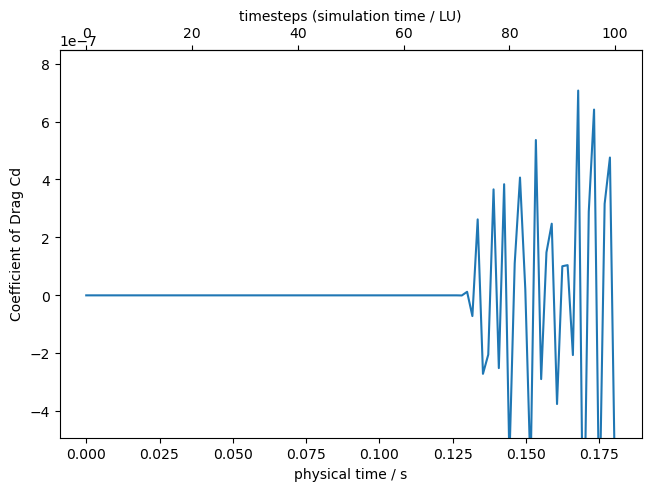

In [21]:
### plot Drag coefficient

drag_coefficient = np.array(Dragreport.out)
#print('  stepLU        ', 'timePU        ', 'Cd')
#print(drag_coefficient) # prints: stepLU, timePU, value

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(drag_coefficient[:,1],drag_coefficient[:,2])
ax.set_xlabel("physical time / s")
ax.set_ylabel("Coefficient of Drag Cd")
ax.set_ylim([0.5,1.6])
ax.set_ylim([0.5,3])
secax = ax.secondary_xaxis('top', functions=(flow.units.convert_time_to_lu, flow.units.convert_time_to_pu))
secax.set_xlabel("timesteps (simulation time / LU)")
if output_data:  # save plot with standard y limits
    plt.savefig(output_path+dir_name+"/drag_coefficient.png")
    np.savetxt(output_path+dir_name+"/drag_coefficient.txt", drag_coefficient, header="stepLU  |  timePU  |  Cd  FROM str(timestamp)")

ax.set_ylim([drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2].min()*0.5,drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2].max()*1.2])
if output_data:  # save plot with adjusted y limits
    plt.savefig(output_path+dir_name+"/drag_coefficient_adjusted.png")
plt.show()

Cd, simple mean:      -3.407285969316334e-08
Cd, peak_finder mean: 1.6348080115959395e-07
start time of 'mean'-ing: 0.16057554361836468


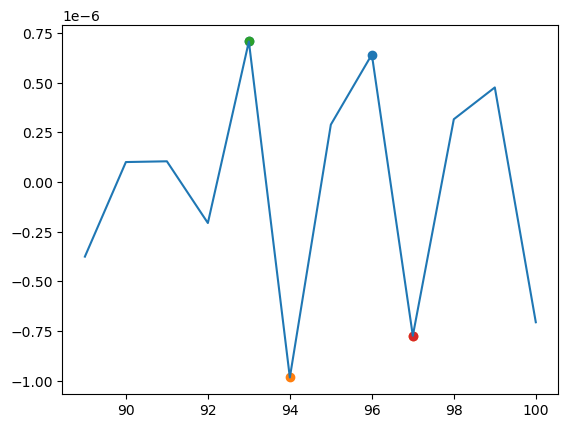

In [22]:
### calculate mean drag_coefficient in periodic region:
try:
    values = drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2]

    peaks_max = find_peaks(values, prominence=((values.max()-values.min())/2))
    peaks_min = find_peaks(-values, prominence=((values.max()-values.min())/2))
    # find peaks only works correctly, if simulation is converged in the periodic region...

    if peaks_min[0].shape[0] - peaks_max[0].shape[0] > 0:
        peak_number = peaks_max[0].shape[0]
    else:
        peak_number = peaks_min[0].shape[0]

    if peaks_min[0][0] < peaks_max[0][0]:
        first_peak = peaks_min[0][0]
        last_peak = peaks_max[0][peak_number-1]
    else:
        first_peak = peaks_max[0][0]
        last_peak = peaks_min[0][peak_number-1]

    drag_mean = values[first_peak:last_peak].mean()
    drag_mean_simple = values.mean()

    print("Cd, simple mean:     ",drag_mean_simple)
    print("Cd, peak_finder mean:",drag_mean)
    print("start time of 'mean'-ing:",drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1),1])
    ## plotting peaks from peak_finder:
    drag_stepsLU = drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,0]
    peak_max_y = values[peaks_max[0]]
    peak_max_x = drag_stepsLU[peaks_max[0]]
    peak_min_y = values[peaks_min[0]]
    peak_min_x = drag_stepsLU[peaks_min[0]]

    plt.plot(drag_stepsLU, values)
    plt.scatter(peak_max_x[:peak_number],peak_max_y[:peak_number])
    plt.scatter(peak_min_x[:peak_number],peak_min_y[:peak_number])
    plt.scatter(drag_stepsLU[first_peak],values[first_peak])
    plt.scatter(drag_stepsLU[last_peak],values[last_peak])
    if output_data:
        plt.savefig(output_path+dir_name+"/drag_coefficient_peakfinder.png")
    peakfinder=True
except:
    print("peak-finding didn't work... probably no significant peaks visible (Re<46?), or periodic region not reached (T too small)")
    values = drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2]
    drag_mean_simple = values.mean()
    peakfinder=False
    print("Cd, simple mean:",drag_mean_simple)

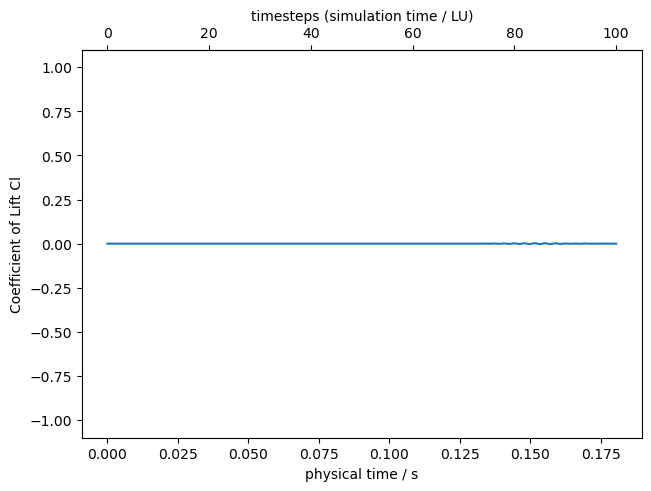

Cl_peaks: 
min -0.0031943969424167783 
max 0.0031391543635031164


In [23]:
### plot Lift coefficient

lift_coefficient = np.array(Liftreport.out)
# print('  stepLU        ', 'timePU        ', 'Cl')
# print(lift_coefficient) # prints: stepLU, timePU, value

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(lift_coefficient[:,1],lift_coefficient[:,2])
ax.set_xlabel("physical time / s")
ax.set_ylabel("Coefficient of Lift Cl")
ax.set_ylim([-1.1,1.1])
secax = ax.secondary_xaxis('top', functions=(flow.units.convert_time_to_lu, flow.units.convert_time_to_pu))
secax.set_xlabel("timesteps (simulation time / LU)")
if output_data:
    plt.savefig(output_path+dir_name+"/lift_coefficient.png")
    np.savetxt(output_path+dir_name+"/lift_coefficient.txt", lift_coefficient, header="stepLU  |  timePU  |  Cl  FROM str(timestamp)")
plt.show()

Cl_min = lift_coefficient[int(lift_coefficient[:,2].shape[0]*0.5):,2].min()
Cl_max = lift_coefficient[int(lift_coefficient[:,2].shape[0]*0.5):,2].max()

print("Cl_peaks: \nmin", Cl_min,"\nmax", Cl_max)

Frequency Peak: 214.01974335108503 +- 5.4876857269508985 Hz


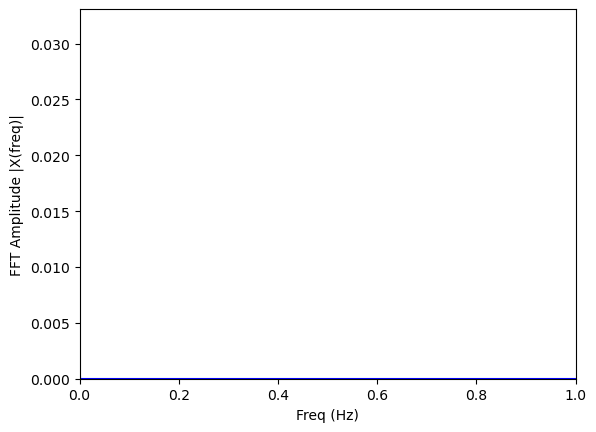

In [24]:
### prototyped fft for frequency detection and calculation of strouhal-number
# ! Drag_frequency is 2* Strouhal-Freq. Lift-freq. is Strouhal-Freq.

try:
    X = np.fft.fft(lift_coefficient[:,2])   # fft result (amplitudes)
    N = len(X)  # number of freqs
    n = np.arange(N)   # freq index
    T = N*flow.units.convert_time_to_pu(1)   # total time measured (T_PU)
    freq = n/T   # frequencies (x-axis of spectrum)

    plt.figure
    plt.stem(freq, np.abs(X), 'b', markerfmt=" ", basefmt="-b")   # plot spectrum |X|(f)
    plt.xlabel("Freq (Hz)")
    plt.ylabel("FFT Amplitude |X(freq)|")
    plt.xlim(0,1)
    #print("max. Amplitude np.abx(X).max():", np.abs(X).max())   # for debugging
    plt.ylim(0,np.abs(X[:int(X.shape[0]*0.5)]).max())   # ylim, where highes peak is on left half of full spectrum

    if output_data:
        plt.savefig(output_path+dir_name+"/fft_Cl.png")

    freq_res = freq[1]-freq[0]   # frequency-resolution
    X_abs = np.abs(X[:int(X.shape[0]*0.4)])   # get |X| Amplitude for left half of full spectrum
    freq_peak = freq[np.argmax(X_abs)]    # find frequency with the highest amplitude
    print("Frequency Peak:", freq_peak, "+-", freq_res, "Hz")
    # f = Strouhal for St=f*D/U and D=U=1 in PU
except:
    print("Strouhal-calculation failed, check simulation data")
    freq_res=0
    freq_peak=0

In [25]:
# save notebook to simulation_output
if output_data:
    try:
        shutil.copy(str(os.getcwd())+"/cylinder3D_development_v2.ipynb",output_path+dir_name+"/script.ipynb")
    except:
        print("script could not be saved")
else:
    print("output_data-toggle is FALSE")

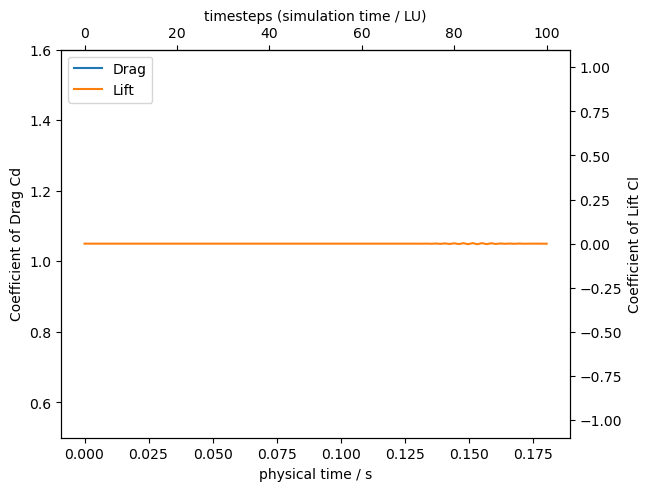

In [26]:
### plot Drag coefficient AND Lift Coefficient

fig, ax = plt.subplots(layout="constrained")
drag_ax = ax.plot(drag_coefficient[:,1],drag_coefficient[:,2], color="tab:blue", label="Drag")
ax.set_xlabel("physical time / s")
ax.set_ylabel("Coefficient of Drag Cd")
ax.set_ylim([0.5,1.6])

secax = ax.secondary_xaxis('top', functions=(flow.units.convert_time_to_lu, flow.units.convert_time_to_pu))
secax.set_xlabel("timesteps (simulation time / LU)")

ax2 = ax.twinx()
lift_ax = ax2.plot(lift_coefficient[:,1],lift_coefficient[:,2], color="tab:orange", label="Lift")
ax2.set_ylabel("Coefficient of Lift Cl")
ax2.set_ylim([-1.1,1.1])


fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax.transAxes)

if output_data:
    plt.savefig(output_path+dir_name+"/dragAndLift_coefficient.png")

plt.show()

In [27]:
### Analysis of GPU memory usage (tensors)

if output_data:
### cudas own memory summary
    print(torch.cuda.memory_summary(device="cuda:0"))
    ### CUDA-VRAM-summary:
    output_file = open(output_path+dir_name+"/"+timestamp + "_GPU_memory_summary.txt", "a")
    output_file.write("DATA for "+timestamp+"\n\n")
    output_file.write(torch.cuda.memory_summary(device="cuda:0"))
    output_file.close()

### list present torch tensors:
    output_file = open(output_path+dir_name+"/"+timestamp + "_GPU_list_of_tensors.txt", "a")
    total_bytes = 0
    import gc
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) or (hasattr(obj,'data') and torch.is_tensor(obj.data)):
                output_file.write("\n"+str(obj.size())+", "+str(obj.nelement()*obj.element_size()))
                total_bytes = total_bytes+obj.nelement()*obj.element_size()
        except:
            pass
    #output_file.write("\n\ntotal bytes for tensors:"+str(total_bytes))
    output_file.close()

### count occurence of tensors in list of tensors:
    from collections import Counter
    my_file = open(output_path+dir_name+"/"+timestamp + "_GPU_list_of_tensors.txt","r")
    data=my_file.read()
    my_file.close()
    data_into_list=data.split("\n")
    c = Counter(data_into_list)
    output_file = open(output_path+dir_name+"/"+timestamp + "_GPU_counted_tensors.txt", "a")
    for k,v in c.items():
        output_file.write("type,size,bytes: {}, number: {}\n".format(k,v) )
    output_file.write("\ntotal bytes for tensors:"+str(total_bytes))
    output_file.close()

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  594212 KB |    2699 MB |    1206 GB |    1205 GB |
|       from large pool |  592800 KB |    2697 MB |    1206 GB |    1205 GB |
|       from small pool |    1412 KB |       2 MB |       0 GB |       0 GB |
|---------------------------------------------------------------------------|
| Active memory         |  594212 KB |    2699 MB |    1206 GB |    1205 GB |
|       from large pool |  592800 KB |    2697 MB |    1206 GB |

/home/mbille/anaconda3/envs/lettuce/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py:262: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


In [28]:
# output data
if output_data:
    output_file = open(output_path+dir_name+"/"+timestamp + "_parms_stats_obs.txt", "a")
    output_file.write("DATA for "+timestamp)
    output_file.write("\n\n###   SIM-Parameters   ###")
    output_file.write("\nRe = "+str(re))
    output_file.write("\nn_steps = "+str(n_steps))
    output_file.write("\nT_target = "+str(flow.units.convert_time_to_pu(n_steps))+" seconds")
    output_file.write("\ngridpoints_per_diameter (gpd) = "+str(gridpoints_per_diameter))
    if gpd_correction:
        output_file.write("\ngpd was corrected from: "+str(gpd_setup)+" to "+str(gridpoints_per_diameter)+" because D/Y is even")
    output_file.write("\nDpX (D/X) = " + str(domain_length_in_D))
    output_file.write("\nDpY (D/Y) = "+str(domain_height_in_D))
    if lattice.D == 3:
        output_file.write("\nDpZ (D/Z) = "+str(domain_width_in_D))
    output_file.write("\nshape_LU: "+ str(flow.shape))
    output_file.write(("\ntotal_number_of_gridpoints: "+str(lattice.rho(sim.f).numel())))
    output_file.write("\nbc_type = "+str(bc_type))
    output_file.write("\nlateral_walls = "+str(lateral_walls))
    output_file.write("\nstencil = "+str(stencil_choice))
    output_file.write("\ncollision = " + str(collision_choice))
    output_file.write("\n")
    output_file.write("\nMa = " + str(Ma))
    output_file.write("\ntau = " + str(tau))
    output_file.write("\ngrid_reynolds_number (Re_g) = " + str(re_g))
    output_file.write("\n")
    output_file.write("\nsetup_diameter_PU = " + str(setup_diameter))
    output_file.write("\nflow_velocity_PU = " + str(flow_velocity))
    output_file.write("\nu_init = " + str(u_init))
    output_file.write("\nperturb_init = " + str(perturb_init))
    output_file.write("\n")
    output_file.write("\noutput_vtk = " + str(output_vtk))
    output_file.write("\nvtk_fps = " + str(vtk_fps))

    output_file.write("\n\n###   SIM-STATS  ###")
    output_file.write("\nruntime = "+str(runtime)+ " seconds (="+str(runtime/60)+" minutes)")
    output_file.write("\nMLUPS = "+str(mlups))
    output_file.write("\n")
    output_file.write("\navg. Collision-Time [s] = " + str(c_time) + " (" + str(round(100 * c_time/sum_time, 2)) + " %)")
    output_file.write("\navg. Streaming-Time [s] = " + str(s_time) + " (" + str(round(100 * s_time/sum_time, 2)) + " %)")
    output_file.write("\navg. Boundary-Time  [s] = " + str(b_time) + " (" + str(round(100 * b_time/sum_time, 2)) + " %)")
    output_file.write("\navg. Reporter-Time  [s] = " + str(r_time) + " (" + str(round(100 * r_time/sum_time, 2)) + " %)")
    output_file.write("\n")
    output_file.write("\nVRAM_current [MB] = " + str(torch.cuda.memory_allocated(lattice.device)/1024/1024))
    output_file.write("\nVRAM_peak [MB] = " + str(torch.cuda.max_memory_allocated(lattice.device)/1024/1024))
    output_file.write("\n")
    output_file.write("\nCPU load % avg. over last 1, 5, 15 min: " + str(round(cpuLoad1, 2)) + " %, " + str(round(cpuLoad5, 2)) + " %, " + str(round(cpuLoad15, 2)) + " %")
    output_file.write("\ntotal current RAM usage [MB]: " + str(round(ram.used/(1024*1024),2)) + " of " + str(round(ram.total/(1024*1024),2)) + " MB")

    output_file.write("\n\n###   OBSERVABLES   ###")
    output_file.write("\nCoefficient of drag between "+str(round(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1),1],2))+" s and "+str(round(drag_coefficient[int(drag_coefficient.shape[0]-1),1],2))+" s:")
    output_file.write("\nCd_mean, simple      = "+str(drag_mean_simple))
    if peakfinder:
        output_file.write("\nCd_mean, peak_finder = "+str(drag_mean))
    else:
        output_file.write("\nnoPeaksFound")
    output_file.write("\nCd_min = "+str(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2].min()))
    output_file.write("\nCd_max = "+str(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2].max()))
    output_file.write("\n")
    output_file.write("\nCoefficient of lift:")
    output_file.write("\nCl_min = "+str(Cl_min))
    output_file.write("\nCl_max = "+str(Cl_max))
    output_file.write("\n")
    output_file.write("\nStrouhal number:")
    output_file.write("\nSt +- df = "+str(freq_peak)+" +- "+str(freq_res)+" Hz")
    output_file.write("\n")
    output_file.close()


In [29]:
if output_data:
    output_file = open(output_path+dir_name+"/"+timestamp + "_parms_stats_obs_copyable.txt", "a")

    output_file.write("DATA for "+timestamp)
    output_file.write("\n\n###   Data:   ###")
    output_file.write("\nRe, n_steps, t_target(PU), GPD, DpX, DpY, (DpZ), shape_LU, gridpoints, bc_type, lateral_walls, stencil, collision, Ma, tau, Re_grid, setup_diameter_PU, flow_velocity_PU, u_init, perturb_init, output_vtk, vtk_fps, runtime, MLUPS, c_time, s_time, b_time, r_time, VRAM_current_MB, VRAM_peak_MB, periodic_start, Cd_mean, Cd_mean_pf, Cd_min, Cd_max, Cl_min, Cl_max, St, df")
    output_file.write("\n" + str(re))
    output_file.write("\n" + str(n_steps))
    output_file.write("\n" + str(flow.units.convert_time_to_pu(n_steps)))
    output_file.write("\n" + str(gridpoints_per_diameter))
    if gpd_correction:
        output_file.write("\ngpd was corrected from: "+str(gpd_setup)+" to "+str(gridpoints_per_diameter)+" because D/Y is even")
    output_file.write("\n" + str(domain_length_in_D))
    output_file.write("\n" + str(domain_height_in_D))
    if lattice.D == 3:
        output_file.write("\n" + str(domain_width_in_D))
    output_file.write("\n" + str(flow.shape))
    output_file.write("\n" + str(lattice.rho(sim.f).numel()))
    output_file.write("\n"+str(bc_type))
    output_file.write("\n"+str(lateral_walls))
    output_file.write("\n"+str(stencil_choice))
    output_file.write("\n" + str(collision_choice))
    output_file.write("\n")
    output_file.write("\n" + str(Ma))
    output_file.write("\n" + str(tau))
    output_file.write("\n" + str(re_g))
    output_file.write("\n")
    output_file.write("\n" + str(setup_diameter))
    output_file.write("\n" + str(flow_velocity))
    output_file.write("\n" + str(u_init))
    output_file.write("\n" + str(perturb_init))
    output_file.write("\n")
    output_file.write("\n" + str(output_vtk))
    output_file.write("\n" + str(vtk_fps))
    output_file.write("\n")

    output_file.write("\n"+str(runtime))
    output_file.write("\n"+str(mlups))
    output_file.write("\n")
    output_file.write("\n" + str(c_time))
    output_file.write("\n" + str(s_time))
    output_file.write("\n" + str(b_time))
    output_file.write("\n" + str(r_time))
    output_file.write("\n")
    output_file.write("\n" + str(torch.cuda.memory_allocated(lattice.device)/1024/1024))
    output_file.write("\n" + str(torch.cuda.max_memory_allocated(lattice.device)/1024/1024))
    output_file.write("\n")

    output_file.write("\n" + str(periodic_start))
    output_file.write("\n"+str(drag_mean_simple))
    if peakfinder:
        output_file.write("\n"+str(drag_mean))
    else:
        output_file.write("\nnoPeaksFound")
    output_file.write("\n"+str(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2].min()))
    output_file.write("\n"+str(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2].max()))
    output_file.write("\n")
    output_file.write("\n"+str(Cl_min))
    output_file.write("\n"+str(Cl_max))
    output_file.write("\n")
    output_file.write("\n"+str(freq_peak))
    output_file.write("\n"+str(freq_res))
    output_file.write("\n")
    output_file.close()

In [30]:
print("current VRAM (MB): ", torch.cuda.memory_allocated(device="cuda:0")/1024/1024)
print("max. VRAM (MB): ", torch.cuda.max_memory_allocated(device="cuda:0")/1024/1024)

current VRAM (MB):  580.28564453125
max. VRAM (MB):  2699.03564453125
